# AEGAN datasets benchmark

In [5]:
import pandas as pd
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.save_step import Save
from sciutil import SciUtil 

u = SciUtil()

# Basically want to run blast on each of the datasets and see how many get the correct active site
# We do this filtering first to remove them from the sequence set
data_dir = '/disk1/ariane/vscode/squidly/aegan_structures/AEGAN_extracted_sequences/'
files = os.listdir(data_dir)
swissprot = pd.read_csv('data/wills_metadata.tsv', sep='\t')

def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('data/AEGAN_real_training_set.txt', header=None)[0].values)
training_df = swissprot[swissprot['Entry'].isin(training_ids)]

u.dp(['Number of AEGAN training set:', len(training_df)])

--------------------------------------------------------------------------------
                      Number of AEGAN training set:	2053	                       
--------------------------------------------------------------------------------


# Now for each test set we want to look for the closest sequence in the AEGAN training set 

We do this for each of the sequneces in AEGAN.

In [8]:
for f in files:
    try:
        df = pd.read_csv(f'{data_dir}{f}/{f}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        # Remove from SwissProt
        # Now we're going to save this as a fasta file 
        fasta_label = f'data/AEGAN/AEGAN_with_active_site_seqs_{f}.fasta'
        with open(fasta_label, 'w+') as fout:
            for entry, seq in training_df[['Entry', 'Sequence']].values:
                if entry not in entries:
                    fout.write(f'>{entry}\n{seq}\n')
        # Do blast on this dataset 
        # This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
        # This contains the models and the data needed to run the tool
        id_col = 'Entry'
        seq_col = 'Sequence'
        df << (BLAST(id_col, seq_col, database=fasta_label, args=['--ultra-sensitive']) >> Save(f'data/AEGAN/blast/{f}_BLAST.pkl'))
    except:
        print(f)

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_PC.fasta
Opening the database file...  [0s]
Loading sequences...  [0.003s]
Masking sequences...  [0.025s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.003s]

Database sequences  2035
  Database letters  809892
     Database hash  15e6849f742511a525876a0d6565d099
        Total time  0.033000s


['diamond', 'blastp', '--ultra-sensitive', '-d', '/tmp/tmpsu244cmo/1xSEyMRlFH_db', '-q', '/tmp/tmpsu244cmo/1xSEyMRlFH_query.fasta', '-o', '/tmp/tmpsu244cmo/1xSEyMRlFH_matches.tsv']
--------------------------------------------------------------------------------
Running command	diamond blastp --ultra-sensitive -d /tmp/tmpsu244cmo/1xSEyMRlFH_db -q /tmp/tmpsu244cmo/1xSEyMRlFH_query.fasta -o /tmp/tmpsu244cmo/1xSEyMRlFH_matches.tsv	
--------------------------------------------------------------------------------


diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmpsu244cmo
#Target sequences to report alignments for: 25
Opening the database...  [0s]
Database: /tmp/tmpsu244cmo/1xSEyMRlFH_db (type: Diamond database, sequences: 2035, letters: 809892)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...  [0s]
Loading query sequences...  [0s]
Masking queries...  [0.02s]
Algorithm: Double-indexed
Building query histograms...  [0.109s]
Seeking in database...  [0s]
Loading reference sequences...  [0s]
Masking reference...  [0.02s]
Initializing temporary storage...  [0.001s]
Building reference histograms...  [0.116s]
Allocating buffers..

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmpsu244cmo
#Target sequences to report alignments for: 25
Opening the database...  [0s]
Database: /tmp/tmpsu244cmo/1xSEyMRlFH_db (type: Diamond database, sequences: 2035, letters: 809892)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...  [0

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_NN.fasta
Opening the database file...  [0s]
Loading sequences...  [0.003s]
Masking sequences...  [0.025s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.003s]

Database sequences  2016
  Database letters  802077
     Database hash  db449419063d7d2c2845593f18374fdf
        Total time  0.033000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates 

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmp0yrwichd
#Target sequences to report alignments for: 25
Opening the database...  [0.001s]
Database: /tmp/tmp0yrwichd/zfnMg01SfQ_db (type: Diamond database, sequences: 2016, letters: 802077)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_EF_superfamily.fasta
Opening the database file...  [0s]
Loading sequences...  [0.003s]
Masking sequences...  [0.024s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.001s]

Database sequences  2010
  Database letters  800236
     Database hash  9ebb2d48bf2d459a6d9d2da7028b1f49
        Total time  0.031000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support 

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmpdfzyoz31
#Target sequences to report alignments for: 25
Opening the database...  [0s]
Database: /tmp/tmpdfzyoz31/ur5HS20W3p_db (type: Diamond database, sequences: 2010, letters: 800236)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...  [0

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_EF_fold.fasta
Opening the database file...  [0s]
Loading sequences...  [0.003s]
Masking sequences...  [0.032s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.003s]

Database sequences  2014
  Database letters  801797
     Database hash  38d4952a4a5e55611ab7a5592529d2a8
        Total time  0.040000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and upd

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmpf3_nvhcb
#Target sequences to report alignments for: 25
Opening the database...  [0.001s]
Database: /tmp/tmpf3_nvhcb/eejfYxhdhG_db (type: Diamond database, sequences: 2014, letters: 801797)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_EF_family.fasta
Opening the database file...  [0s]
Loading sequences...  [0.003s]
Masking sequences...  [0.023s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.003s]

Database sequences  1989
  Database letters  790296
     Database hash  251d079b33d77dce48ac5090ca3fa592
        Total time  0.031000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and u

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmpfcvhs2p6
#Target sequences to report alignments for: 25
Opening the database...  [0.001s]
Database: /tmp/tmpfcvhs2p6/rPqm5jMOy7_db (type: Diamond database, sequences: 1989, letters: 790296)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_HA_superfamily.fasta
Opening the database file...  [0s]
Loading sequences...  [0.003s]
Masking sequences...  [0.031s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.003s]

Database sequences  2001
  Database letters  797736
     Database hash  0ad3f5e57884bb5ce58ac4db70f2f0b7
        Total time  0.039000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support 

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmpz_00_d4h
#Target sequences to report alignments for: 25
Opening the database...  [0.001s]
Database: /tmp/tmpz_00_d4h/ozDjj0ivrj_db (type: Diamond database, sequences: 2001, letters: 797736)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...

# For each of these now what we want to do is to pull out the familiies and align using the clustal omega 

In [9]:
files = os.listdir('data/AEGAN/blast/')
results = {}
for f in files:
    try:
        label = f.split('_BLAST.pkl')[0]
        df = pd.read_csv(f'{data_dir}{label}/{label}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        blast_df = pd.read_pickle(f'data/AEGAN/blast/{f}')
        blast_df = blast_df.sort_values(by='sequence identity', ascending=False)
        blast_df.drop_duplicates('query', inplace=True)
        # Then join up with all df
        blast_df.set_index('query', inplace=True)
        df.set_index('Entry', inplace=True)
        df = df.join(blast_df, how='left')
        results[f] = df
        uniprot_id_to_seq = dict(zip(training_df.Entry, training_df.Sequence))
        for name, seq, uniprot in df[['From', 'Sequence', 'target']].values:
            fin = f'msa/{uniprot}_{name}.fa'
            with open(fin, 'w+') as fout:
                fout.write(f'>{uniprot}\n{uniprot_id_to_seq.get(uniprot)}\n')
                fout.write(f'>{name}\n{seq}')
            # Now run clustalomega
            os.system(f'clustalo --force -i {fin} -o {fin.replace(".fa", ".msa")}')
    except:
        print(f)

# Read in the datasets and annotate the residues predicted by BLAST

In [12]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Read in squidly results
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm 

def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    agree, disagree, none_ = 0, 0, 0
    percent_aggree = []
    to_check = []
    missing = 0
    predictions = []
    true = []
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        if not res_sq:
            missing += 1
        else:
            # Calculate the F1 score
            res_sq = res_sq.split('|')
            if not res_pred or not isinstance(res_pred, str):
                none_ += 1
                percent_aggree.append(0)
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    predictions.append(0) # Since we had no true predictions
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
            else:
                res_pred = res_pred.split('|')
                if res_sq != res_pred:
                    to_check.append(seq_label)
                    # Check the % agree 
                    percent_aggree.append(len(set(res_sq) & set(res_pred))/max(len(res_sq), len(res_pred)))
                    disagree += 1
                else:
                    percent_aggree.append(1)
                    agree += 1
                chosen_res_seq = [int(i) for i in res_pred]
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
                    if pos in chosen_res_seq:
                        predictions.append(1)
                    else:
                        predictions.append(0)

    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    # f1, precision, recall, support, agree, disagree, no_pred, mean_agreement
    return precision[1], recall[1], f1[1], support[1], agree/len(df), disagree/len(df), none_/len(df), np.mean(percent_aggree)


In [118]:
colors = ['#FFC440', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64']
order = ['EF_family', 
         'NN',
         'HA_superfamily',
         'PC',
         'EF_fold',
         'EF_superfamily',
         ]


--------------------------------------------------------------------------------
EF_family	
F1	0.7752808988764044	
precision:	0.9452054794520548	
 recall:	0.6571428571428571	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
NN	
F1	0.6603773584905661	
precision:	0.813953488372093	
 recall:	0.5555555555555556	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
HA_superfamily	
F1	0.5874125874125874	
precision:	0.84	
 recall:	0.45161290322580644	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
    PC	
F1	0.888888888888889	
precision:	0.96	
 recall:	0.8275862068965517	     
--------------------------------------------------------------------------------
-----

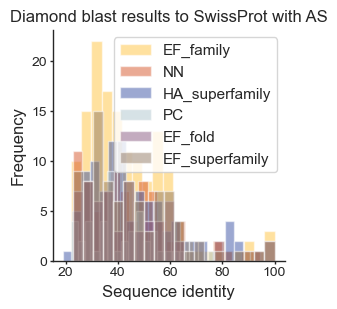

In [166]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np

uniprot_id_to_active_site = dict(zip(training_df['Entry'], training_df['Residue']))
dataset_to_blast = {}
for di, df_label in enumerate(order):
    df_label = df_label + '_BLAST.pkl'
    df = results[df_label]
    predicted_active_sites = {}
    missing = 0
    for query, uniprot in df[['From', 'target']].values:
        try:
            fin = f'msa/{uniprot}_{query}.msa'
            # Read with bioseq
            # Read the alignment
            active_sites = [int(x) for x in uniprot_id_to_active_site.get(uniprot).split('|')]
            alignment = AlignIO.read(fin, 'fasta')
            # get the existing one and then calculate the position gapped
            records = {}
            for record in alignment:
                records[record.id] = record.seq
            # Now get the active site
            position_count = 0
            active_pred = []
            query_seq = records[query]
            query_count = 0
            x = 0
            for i, v in enumerate(records[uniprot]):
                if position_count in active_sites:
                    if query_count < len(query_seq.replace('-', '')):
                        active_pred.append(query_count)
                    if query_seq[i] != v:
                        x += 1
                        #print(query, uniprot, v, query_seq[i])
                if v != '-':
                    position_count += 1
                if query_seq[i] != '-' and query_seq[i] != ' ':
                    query_count += 1
        
            predicted_active_sites[query] = '|'.join([str(s) for s in active_pred])
            # Now we can just add on the
        except:
            missing += 1
    
    df['BLAST_residues'] = [predicted_active_sites.get(label) for label in df['From'].values]
    df['True_residues'] = [uniprot_id_to_active_site.get(label) for label in df['From'].values]
    results[df_label] = df
    df.to_csv(f'data/AEGAN/blast/{df_label.replace(".pkl", ".csv")}')
    
    # Check the agreement:
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'True_residues', 'BLAST_residues', 'Sequence')
    dataset_to_blast[df_label.replace("_BLAST.pkl", "")] = {'recall': recall, 'f1': f1, 'precision': precision}

    u.dp([df_label.replace("_BLAST.pkl", ""), '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])
    # Add the seq identity plot
    plt.hist(df['sequence identity'].values, bins=20, label=df_label.replace("_BLAST.pkl", ""), color=colors[di], alpha=0.5)
             
plt.title('Diamond blast results to SwissProt with AS')
plt.legend()
ax = clean_plt(plt.gca())
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
plt.savefig(f'figures/DiamondBlast_histogram_{f}.svg')

In [167]:
def ensemble_predictions(df, blast_col, squidly_col, seq_id_col, squidly_similarity_cutoff=30):
    # Basically we update the choice of blast and squidly based on the cutoff 
    chosen_residues = []
    for blast_res, squidly_res, seq_id in df[[blast_col, squidly_col, seq_id_col]].values:
        # Also check if both are here otherwise pick the other one that was predicted
        if not isinstance(blast_res, str):
            chosen_residues.append(squidly_res)
        elif not isinstance(squidly_res, str):
            chosen_residues.append(blast_res)
        elif seq_id < squidly_similarity_cutoff:
            chosen_residues.append(squidly_res)
        elif seq_id >= squidly_similarity_cutoff:
            chosen_residues.append(blast_res)
        else:
            chosen_residues.append(None)
    df['chosen_residues'] = chosen_residues
    return df

rows = []
for squidly_cutoff in tqdm(range(0, 100, 2)):
    for df_label in results:
        if df_label == 'label':
            continue
        df = results[df_label]
        squidly_df = pd.read_pickle(f'data/AEGAN/squidly/squidly_as_pred_{df_label.replace("_BLAST", "")}')
        squidly_df.set_index('label', inplace=True)
        df = df.join(squidly_df, how='left')
        # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
        tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
        precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
        rows.append([df_label.replace(".pkl", ""), squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.45it/s]


In [168]:
dataset_to_blast

{'EF_family': {'recall': 0.6571428571428571,
  'f1': 0.7752808988764044,
  'precision': 0.9452054794520548},
 'NN': {'recall': 0.5555555555555556,
  'f1': 0.6603773584905661,
  'precision': 0.813953488372093},
 'HA_superfamily': {'recall': 0.45161290322580644,
  'f1': 0.5874125874125874,
  'precision': 0.84},
 'PC': {'recall': 0.8275862068965517,
  'f1': 0.888888888888889,
  'precision': 0.96},
 'EF_fold': {'recall': 0.5230769230769231,
  'f1': 0.6538461538461539,
  'precision': 0.8717948717948718},
 'EF_superfamily': {'recall': 0.6027397260273972,
  'f1': 0.7394957983193277,
  'precision': 0.9565217391304348}}

In [169]:
df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
df['Dataset'] = [d.replace('_BLAST', '') for d in df['Dataset'].values]
df.to_csv('data/Ensemble_Squidly_AEGAN_3B.csv', index=False)

In [170]:
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3,3)
sns.set(rc={'figure.figsize': (3,3), 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 12}, 
        style='ticks')

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
    
def make_figure(df, x, y, hue, filename):
    ax = sns.lineplot(df, x=x, y=y, hue=hue, 
                         hue_order=order,
                         palette=colors, legend=None)
    ax.axvline(30, c='black', linestyle = 'dashed')
    ax = sns.scatterplot(df, x=x, y=y, hue=hue, 
                         hue_order=order, ax=ax,
                         palette=colors, s=10, legend=None)
    for i, ds in enumerate(order):
        ax.axhline(dataset_to_blast.get(ds).get(y.lower()), c=colors[i], linestyle='dashed')
    ax = clean_plt(ax)
    plt.title(f'{filename.replace(".svg", "")}')
    plt.ylim(0.45, 1.0)
    plt.xlim(15, 75)
    plt.savefig(f'figures/{filename}')
    plt.show()
    

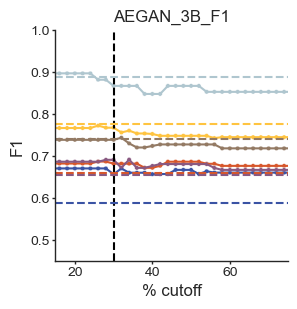

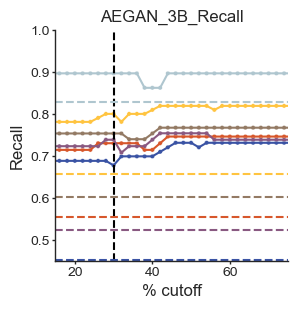

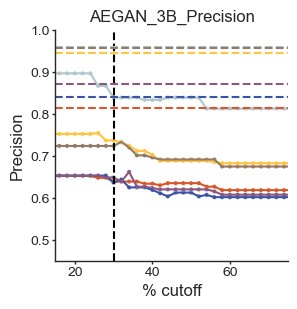

In [171]:
make_figure(df, x='% cutoff', y='F1', hue='Dataset', filename='AEGAN_3B_F1.svg')
make_figure(df, x='% cutoff', y='Recall', hue='Dataset', filename='AEGAN_3B_Recall.svg')
make_figure(df, x='% cutoff', y='Precision', hue='Dataset', filename='AEGAN_3B_Precision.svg')

In [172]:
df[df['% cutoff'] == 30]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
90,NN,30,0.681481,0.638889,0.730159,63,0.157407,0.166667,0.018519,0.626126
91,HA_superfamily,30,0.656250,0.636364,0.677419,93,0.131579,0.203947,0.006579,0.608974
92,PC,30,0.866667,0.838710,0.896552,29,0.218182,0.090909,0.018182,0.796296
93,EF_fold,30,0.690647,0.648649,0.738462,65,0.225806,0.182796,0.010753,0.664530
94,EF_superfamily,30,0.738255,0.723684,0.753425,73,0.235772,0.113821,0.000000,0.759690
95,EF_family,30,0.767123,0.736842,0.800000,105,0.219388,0.096939,0.010204,0.769271


In [173]:
df[df['% cutoff'] == 40]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
120,NN,40,0.671642,0.633803,0.714286,63,0.148148,0.175926,0.018519,0.619369
121,HA_superfamily,40,0.656566,0.619048,0.698925,93,0.131579,0.203947,0.006579,0.618590
122,PC,40,0.847458,0.833333,0.862069,29,0.200000,0.109091,0.018182,0.777778
123,EF_fold,40,0.676056,0.623377,0.738462,65,0.204301,0.193548,0.021505,0.644872
124,EF_superfamily,40,0.723684,0.696203,0.753425,73,0.211382,0.138211,0.000000,0.746124
125,EF_family,40,0.752212,0.702479,0.809524,105,0.193878,0.117347,0.015306,0.738021


In [174]:
rows = []
for squidly_cutoff in tqdm(range(0, 100, 2)):
    for df_label in results:
        if df_label == 'label':
            continue
        df = results[df_label]
        squidly_df = pd.read_pickle(f'data/AEGAN/squidly/squidly_as_pred_15B_{df_label.replace("_BLAST", "")}')
        squidly_df.set_index('label', inplace=True)
        df = df.join(squidly_df, how='left')
        # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
        tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
        precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
        rows.append([df_label.replace(".pkl", ""), squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.53it/s]


In [175]:
df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
df.to_csv('data/Ensemble_Squidly_15B.csv', index=False)

In [176]:
df['Dataset'] = [d.replace('_BLAST', '') for d in df['Dataset'].values]

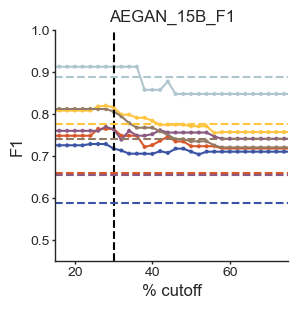

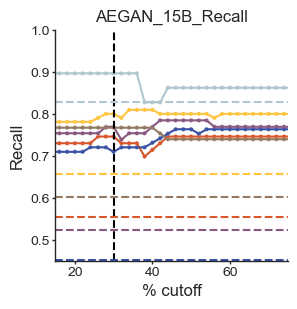

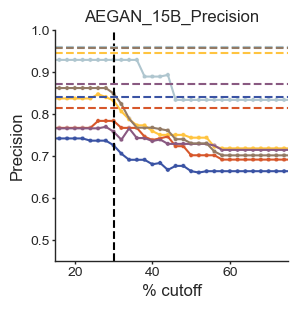

In [177]:
make_figure(df, x='% cutoff', y='F1', hue='Dataset', filename='AEGAN_15B_F1.svg')
make_figure(df, x='% cutoff', y='Recall', hue='Dataset', filename='AEGAN_15B_Recall.svg')
make_figure(df, x='% cutoff', y='Precision', hue='Dataset', filename='AEGAN_15B_Precision.svg')

In [178]:
df[df['% cutoff'] == 30]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
90,NN,30,0.764228,0.783333,0.746032,63,0.194444,0.111111,0.037037,0.684685
91,HA_superfamily,30,0.717391,0.725275,0.709677,93,0.157895,0.171053,0.013158,0.649679
92,PC,30,0.912281,0.928571,0.896552,29,0.272727,0.036364,0.018182,0.861111
93,EF_fold,30,0.763359,0.757576,0.769231,65,0.236559,0.150538,0.032258,0.681624
94,EF_superfamily,30,0.805755,0.848485,0.767123,73,0.243902,0.089431,0.016260,0.775194
95,EF_family,30,0.815534,0.831683,0.800000,105,0.214286,0.091837,0.020408,0.765625


In [179]:
df[df['% cutoff'] == 40]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
120,NN,40,0.725806,0.737705,0.714286,63,0.175926,0.129630,0.037037,0.669820
121,HA_superfamily,40,0.704663,0.680000,0.731183,93,0.138158,0.190789,0.013158,0.642308
122,PC,40,0.857143,0.888889,0.827586,29,0.254545,0.054545,0.018182,0.824074
123,EF_fold,40,0.751880,0.735294,0.769231,65,0.193548,0.193548,0.032258,0.664530
124,EF_superfamily,40,0.767123,0.767123,0.767123,73,0.186992,0.146341,0.016260,0.713178
125,EF_family,40,0.783410,0.758929,0.809524,105,0.163265,0.142857,0.020408,0.697917
